In [1]:
import numpy as np
from numba import vectorize
import matplotlib.pyplot as plt
import torch
plt.style.use(['science','notebook'])

import sys
sys.path.insert(0, '../src/pydftlj')
from dft3dgpu import dft3d

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2023-04-27

/home/elvis/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available(): print(torch.cuda.get_device_properties(device))

In [3]:
@vectorize
def ljpotential(r,eps,sigma):
    return 4*eps*((sigma/r)**(12)-(sigma/r)**(6))

# Defining the fluid properties

In [4]:
# fluid properties
sigma = 1.0
epsilon = 1.0
L = 10.0*sigma
# Temperature and Density 
kT = 2.934
rhob = 0.450

# Defining the functional 


In [5]:
# Test the HS functional 
Ngrid = 128
DFT = dft3d(gridsize=(Ngrid,Ngrid,Ngrid),ljmethod='WDA')
DFT.Set_Geometry(L=L)
DFT.Set_FluidProperties(sigma=sigma,epsilon=epsilon)
DFT.Set_Temperature(kT)
DFT.Set_BulkDensity(rhob)

In [6]:
DFT.delta

array([0.078125, 0.078125, 0.078125])

In [7]:
R = np.sqrt(DFT.X**2+DFT.Y**2+DFT.Z**2+1e-16)
Vext = ljpotential(R,epsilon,sigma)
DFT.Set_External_Potential(Vext)

del R

(-5.0390625, 4.9609375, -5.0390625, 4.9609375)

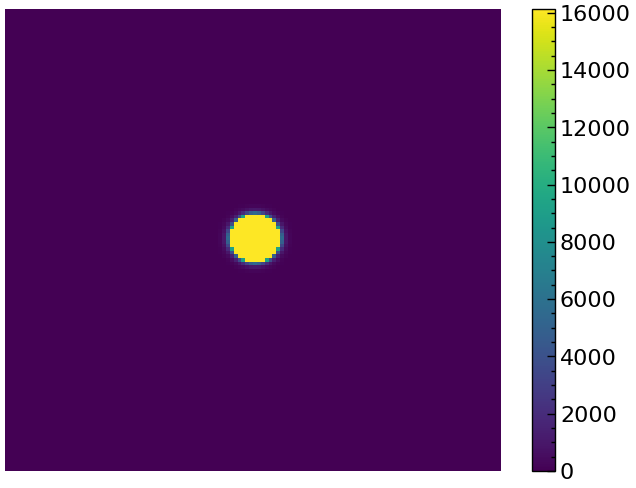

In [8]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFT.X[:,:,Ngrid//2],DFT.Y[:,:,Ngrid//2],DFT.Vext[:,:,Ngrid//2].cpu(), cmap='viridis')
plt.colorbar(c)
plt.axis('off')

## Setting the Initial Condition

In [9]:
DFT.Set_InitialCondition()

/home/elvis/Google Drive/Projetos em Andamento/2-DFT in Amorphous Carbon/codes/PyDFTlj/examples/../src/pydftlj/dft3dgpu.py:162: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  self.n3[:] = torch.fft.ifftn(self.rho_hat*self.w3_hat).cpu()


In [10]:
DFT.rho.min(),DFT.rho.max()

(tensor(0.), tensor(0.4500))

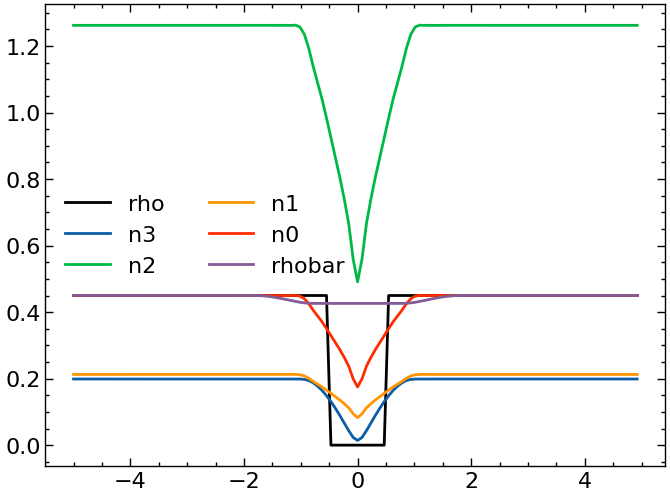

In [11]:
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.rho[:,Ngrid//2,Ngrid//2].numpy(),color='k',label='rho')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n3[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n3')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n2[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n2')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n1[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n1')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n0[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n0')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.rhobar[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='rhobar')
plt.legend(loc='best',ncols=2)

## Calculate Equilibrium

In [12]:
# DFT.Calculate_Equilibrium(alpha0=0.6,rtol=1e-1,atol=1e-2,max_iter=15,method='picard',logoutput=True)
DFT.Calculate_Equilibrium(alpha0=0.25,dt=0.5,rtol=1e-3,atol=1e-4,method='fire',logoutput=True)

0 -384.56042 66731692.0
1 -1814.1758 193976.58
2 -1817.0868 37415.074


/home/elvis/Google Drive/Projetos em Andamento/2-DFT in Amorphous Carbon/codes/PyDFTlj/examples/../src/pydftlj/dft3dgpu.py:181: RuntimeWarning: invalid value encountered in dphi3dnfuncWBI
  self.dphi3dn3 = torch.tensor(dphi3dnfuncWBI(self.n3.numpy()),dtype=torch.float32)


3 -1817.3865 25347.047
4 -1815.3923 103126.85
5 -1817.3496 29045.805
6 -1817.3662 28550.684
7 -1817.4327 20403.74
8 -1817.4359 20199.201
9 -1817.4368 20064.951
10 -1817.5032 3773.1733
11 -1817.4624 15722.399
12 -1791.0908 500662.56
13 -1817.0653 51959.043
14 -1815.1523 110143.914
15 -1816.1522 83373.164
16 -1816.1204 84895.68
17 -1817.4877 9128.732
18 -1816.5198 79269.18
19 -1817.4445 19360.926
20 -1817.4342 20310.414
21 -1817.3708 27959.941
22 -1817.4983 6371.283
23 -1817.4819 11676.442
24 -1817.4922 8941.065
25 -1817.502 4535.8706
26 -1817.506 754.8314
27 -1817.5037 4081.3425
28 -1817.5038 3216.1858
29 -1817.5044 2970.302
30 -1817.5051 2587.5603
31 -1817.5054 2087.6887
32 -1817.5055 1501.8724
33 -1817.5061 871.2558
34 -1817.5057 263.53824
35 -1817.5057 289.01822
36 -1817.5061 591.19763
37 -1817.5061 654.77246
38 -1817.5061 509.35602
39 -1817.5063 217.86006
40 -1817.506 185.86955
41 -1817.5059 100.173065
42 -1817.5055 97.970406
43 -1817.5057 94.61076
44 -1817.506 90.26081
45 -1817.505

In [13]:
DFT.Niter

86

In [14]:
DFT.rho.min(),DFT.rho.max()

(tensor(0.), tensor(0.7285))

In [15]:
DFT.Omega

tensor(-1817.5057)

(-5.0390625, 4.9609375, -5.0390625, 4.9609375)

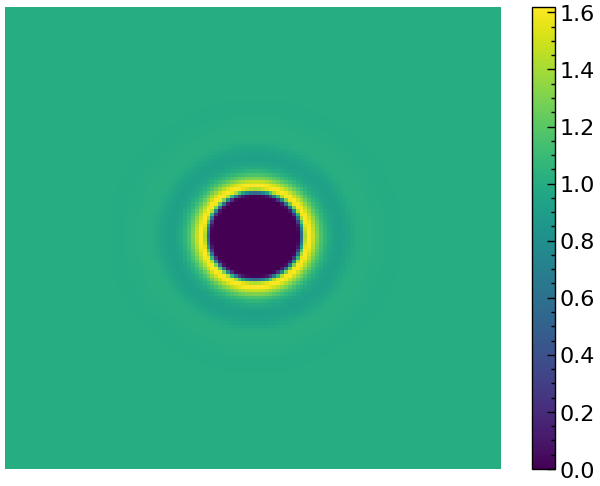

In [16]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFT.X[:,:,Ngrid//2],DFT.Y[:,:,Ngrid//2],DFT.rho[:,:,Ngrid//2].numpy()/rhob, cmap='viridis')
plt.colorbar(c)
plt.axis('off')

In [21]:
zwda,rhowda = np.load(f'radialdistribution-3D-rhob={rhob}-kT={kT}-Ngrid=128-ljmethod=WDA.npy')
zmmfa,rhommfa = np.load(f'radialdistribution-3D-rhob={rhob}-kT={kT}-Ngrid=128-ljmethod=MMFA.npy')

## Plotting g(r)

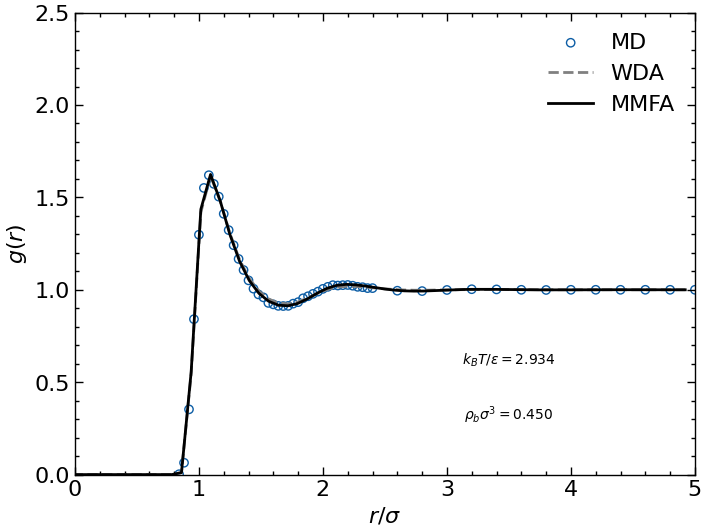

In [23]:
import pandas as pd
df = pd.read_excel('data/MC/MCdata-radialdistribution-lennardjones-Verlet1968.xls',sheet_name='rhob=0.450')
plt.scatter(df['r'],df['KT=2.934'],marker='o',edgecolors='C0',facecolors='none',label='MD')
plt.plot(zwda,rhowda,'--',color='grey',label=r'WDA')
plt.plot(zmmfa,rhommfa,'-',color='k',label=r'MMFA')
# plt.plot(DFT.Z[Ngrid//2,Ngrid//2,:],DFT.rho[Ngrid//2,Ngrid//2,:].numpy()/rhob,'-',color='k',label=r'3D-DFT')
plt.xlim(0.0,5)
plt.ylim(0,2.5)
plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$g(r)$')
plt.text(3.5,0.6,r'$k_B T/\epsilon = 2.934$',ha='center')
plt.text(3.5,0.3,r'$\rho_b \sigma^3 = 0.450$',ha='center')
plt.legend(loc='upper right',ncol=1)

In [19]:
np.save(f'radialdistribution-3D-rhob={rhob}-kT={kT}-Ngrid={Ngrid}-ljmethod={DFT.ljmethod}.npy',(DFT.Z[Ngrid//2,Ngrid//2,:],DFT.rho[Ngrid//2,Ngrid//2,:].numpy()/rhob))